# Conformal prediction for classification - from the ground up

This blog post is based heavily on Chris Molner's book - Introduction to Conformal Prediction with Python:

https://christophmolnar.com/books/conformal-prediction/

Chris is brilliant at making new machine learning techniques accessible to others. I'd especially also look at his books on Explainable Machine Learning.

## What is Conformal Prediction?

Conformal prediction is both a method of uncertainty quantification, and a method of classifying instances (which may be fine-tuned for subgroups). At the same time it also identifiers outliers in the data!

Conformal prediction specifies a coverage, which specifies the probability that the true outcome is covered by the prediction region. The interpretation of prediction regions in conformal prediction depends on the task. For classification we get prediction sets, while for regression we get prediction intervals.

Below is an example of the difference between 'traditional' classification (balance of likelihood) and conformal prediction (sets).

<p align="center">
  <img src="./images/conformal_sets.png" width="600">
</p>

The advantages of this method are:

- **Guaranteed coverage**: Prediction regions generated by conformal prediction come with coverage guarantees of the true outcome. Bootstrapping, by comparison, often under-estimates uncertainty. Multi-class classification especially is often difficult to calibrate well. Conformal prediction does not depend on a well calibrated model - the only thing that matters is that, like all machine learning, the new samples being classified must come from similar data distributions to the training and calibration data. Coverage can also be guaranteed across classes or subgroups, though this takes an extra step in the method which we will cover.
 
- **Easy to use**: Conformal prediction approaches can be implemented from scratch with just a few lines of code.

- **Model-agnostic**: Conformal prediction works with any machine learning model. It uses the normal outputs of whatever you preferred model is.

- **Distribution-free**: Conformal prediction makes no assumptions about underlying distributions of data; it is a non-parametric method.

- **No retraining required**: Conformal prediction can be used without retraining your model. It is another way of looking at, and using, model outputs.

- **Broad application**: conformal prediction works for tabular data classification, image or time-series classification, regression, and many other tasks, though we will demonstrate just classification here.

## Why should we care about uncertainty quantificiation?

Uncertainty quantification is essential in many situations:

- When we use model predictions to make decisions. How sure are we of those predictions?

- When we want to design robust systems that can handle unexpected situations - highlighting when the model has poor prediction certainty for a new instance that lies outside the region the model is robust for.

- When we want to communicate the uncertainty associated with our predictions to stakeholders.


## Alpha in conformal prediction - describes *coverage*

*Coverage* is key to conformal prediction. In classification it is the normal region of data that a particular class inhabits. Coverage is equivalent to *sensitivity* or *recall*; it is the proportion of observed values that are identified in the classification sets. We can tighten or loosen the area of coverage by adjusting $\alpha$ (coverage = 1 - $\alpha$.).



## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Create synthetic data for classification

Example data will be produced using SK-Learn's `make_blobs` method.

In [2]:
n_classes = 3
# Make train and test data
X, y = make_blobs(n_samples=10000, n_features=2, centers=n_classes, cluster_std=3.7, random_state=42)

# Reduce the size of the first class to create an imbalanced dataset
# Get index of when y is class 0
class_0_idx = np.where(y == 0)[0]
# Get 30% of the class 0 indices
class_0_idx = np.random.choice(class_0_idx, int(len(class_0_idx) * 0.3), replace=False)
# Get the index for all other classes
rest_idx = np.where(y != 0)[0]
# Combine the indices
idx = np.concatenate([class_0_idx, rest_idx])
# Shuffle the indices
np.random.shuffle(idx)
# Split the data
X = X[idx]
y = y[idx]

# Split off model training set
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.5, random_state=42)
# Split rest into calibration and test
X_Cal, X_test, y_cal, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

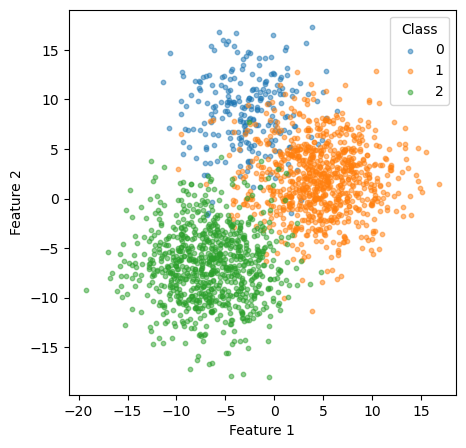

In [3]:
# Plot the data
fig = plt.subplots(figsize=(5, 5))
ax = plt.subplot(111)
for i in range(n_classes):
    ax.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1], label=i, alpha=0.5, s=10)
legend = ax.legend()
legend.set_title("Class")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.show()

## Conformal classification

### Build a classifier

In [4]:
# Build and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

### Calculate conformal prediction threshold

We will now predict classiifcation probabilitlites of the calibration set. This will be used to set a classification threshold for new data.

In [5]:
# Get predictions for calibration set
y_pred = classifier.predict(X_Cal)
y_pred_proba = classifier.predict_proba(X_Cal)

# Show first 5 instances
y_pred_proba[0:5]

array([[6.37144445e-01, 3.62836184e-01, 1.93713591e-05],
       [8.73451745e-03, 9.91066044e-01, 1.99438094e-04],
       [1.86307114e-07, 2.24291939e-05, 9.99977384e-01],
       [8.17579971e-06, 2.28809463e-05, 9.99968943e-01],
       [1.63947690e-01, 7.88393474e-01, 4.76588365e-02]])

### Calculate $s_i$ (non-confmality) scores

Here we will calculate $s_i$ scores only based on looking at probabilities associated with the observed class.

For each instance we will get the predicted probability for the class of that instance.

The $s_i$ score (non-conformality) is $1-probability$.

The higher the $s_i$ score, the less that example conforms to that class in comparison to other classes.

In [6]:
si_scores = []
# Loop through all calibration instances
for i, true_class in enumerate(y_cal):
    # Get predicted probability for observed/true class
    predicted_prob = y_pred_proba[i][true_class]
    si_scores.append(1 - predicted_prob)    

# Convert to NumPy array
si_scores = np.array(si_scores)

# Show first 5 instances
si_scores[0:5]

array([3.62855555e-01, 8.93395554e-03, 2.26155010e-05, 3.10567460e-05,
       8.36052310e-01])

### Get 95th percentile threshold

The threshold determines what *coverage* our classification will have. Coverage refers to the proportion of predictions that actually contain the true outcome. 

The threshold is the percentile corresponding to $1-\alpha$. To get 95% coverage, we set an $\alpha$ of 0.05.

When used in real life, the quantile level (based on 𝛼) requires a finite sample correction to calculate the corresponding quantile 𝑞. We multiple 0.95  by $(n+1)/n$, which means that 𝑞𝑙𝑒𝑣𝑒𝑙 would be 0.951 for n = 1000.

In [7]:
number_of_samples = len(X_Cal)
alpha = 0.05
qlevel = (1 - alpha) * ((number_of_samples + 1) / number_of_samples)
threshold = np.percentile(si_scores, qlevel*100)
print(f'Threshold: {threshold:0.3f}')

Threshold: 0.555


Show chart of $s_1$ values, with cut-off threshold.

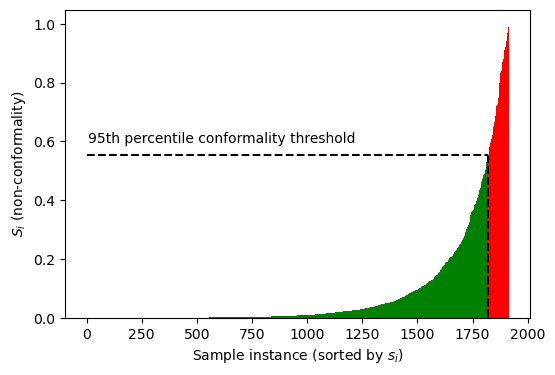

In [8]:
x = np.arange(len(si_scores)) + 1
sorted_si_scores = np.sort(si_scores)
index_of_95th_percentile = int(len(si_scores) * 0.95)

# Color by cut-off
conform = 'g' * index_of_95th_percentile
nonconform = 'r' * (len(si_scores) - index_of_95th_percentile)
color = list(conform + nonconform)

fig = plt.figure(figsize=((6,4)))
ax = fig.add_subplot()

# Add bars
ax.bar(x, sorted_si_scores, width=1.0, color = color)

# Add lines for 95th percentile
ax.plot([0, index_of_95th_percentile],[threshold, threshold], 
        c='k', linestyle='--')
ax.plot([index_of_95th_percentile, index_of_95th_percentile], [threshold, 0],
        c='k', linestyle='--')

# Add text
txt = '95th percentile conformality threshold'
ax.text(5, threshold + 0.04, txt)

# Add axis labels
ax.set_xlabel('Sample instance (sorted by $s_i$)')
ax.set_ylabel('$S_i$ (non-conformality)')

plt.show()

### Get samples/classes from test set classified as positive

We can now find all those model outputs less than the threshold.

It is possible for an individual example to have no value, or more than one value, below the threshold.

In [9]:
prediction_sets = (1 - classifier.predict_proba(X_test) <= threshold)
# Show first ten instances
prediction_sets[0:10]

array([[ True,  True, False],
       [False, False,  True],
       [False, False,  True],
       [False,  True, False],
       [False,  True, False],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False,  True, False],
       [False, False,  True]])

Get prediction set labels.

In [10]:
class_labels = ['blue', 'orange', 'green']

def get_prediction_set_labels(prediction_set, class_labels):
    # Get set of class labels for each instance in prediction sets
    prediction_set_labels = [
        set([class_labels[i] for i, x in enumerate(prediction_set) if x]) for prediction_set in 
        prediction_sets]
    return prediction_set_labels

prediction_set_labels = get_prediction_set_labels(prediction_sets, class_labels)
prediction_set_labels[0:10]

[{'blue', 'orange'},
 {'green'},
 {'green'},
 {'orange'},
 {'orange'},
 {'green'},
 {'green'},
 {'green'},
 {'orange'},
 {'green'}]

### Show coverage and average set size

*Coverage* is the proportion of prediction sets that actually contain the true outcome.

*Average set size* is the average number of predicted classes per instance.

We will define some functions to calculate the results.

In [11]:
# Get class counts
def get_class_counts(y_test):
    class_counts = []
    for i in range(n_classes):
        class_counts.append(np.sum(y_test == i))
    return class_counts

# Get coverage for each class
def get_coverage_by_class(prediction_sets, y_test):
    coverage = []
    for i in range(n_classes):
        coverage.append(np.mean(prediction_sets[y_test == i, i]))
    return coverage

# Get average set size for each class
def get_average_set_size(prediction_sets, y_test):
    average_set_size = []
    for i in range(n_classes):
        average_set_size.append(
            np.mean(np.sum(prediction_sets[y_test == i], axis=1)))
    return average_set_size     

# Get weighted coverage (weighted by class size)
def get_weighted_coverage(coverage, class_counts):
    total_counts = np.sum(class_counts)
    weighted_coverage = np.sum((coverage * class_counts) / total_counts)
    weighted_coverage = round(weighted_coverage, 3)
    return weighted_coverage

# Get weighted set_size (weighted by class size)
def get_weighted_set_size(set_size, class_counts):
    total_counts = np.sum(class_counts)
    weighted_set_size = np.sum((set_size * class_counts) / total_counts)
    weighted_set_size = round(weighted_set_size, 3)
    return weighted_set_size

Show results for each class.

In [12]:
results = pd.DataFrame(index=range(n_classes))
results['Class counts'] = get_class_counts(y_test)
results['Coverage'] = get_coverage_by_class(prediction_sets, y_test)
results['Average set size'] = get_average_set_size(prediction_sets, y_test)
results

,Class counts,Coverage,Average set size
0,241,0.829876,1.037344
1,844,0.936019,1.015403
2,832,0.968750,1.000000


Show overall results

In [13]:
weighted_coverage = get_weighted_coverage(
    results['Coverage'], results['Class counts'])

weighted_set_size = get_weighted_set_size(
    results['Average set size'], results['Class counts'])

print (f'Overall coverage: {weighted_coverage}')
print (f'Average set size: {weighted_set_size}')

Overall coverage: 0.937
Average set size: 1.011


NOTE: Though our overall coverage is as desired, being very close to 95%, coverage of the different classes varies, and is lowest (83%) for our smallest class. If coverage of individual classes is important we can set out thresholds for classes independently, which is what we will now do.

## Conformal classification with equal coverage across classes

When we want to be sure of coverage across all classes, we can set thresholds for each class independently.

Note: we could also do this for subgroups of data, such as ensuring equal coverage for a diagnostic across racial groups, if we found coverage using a shared threshold led to problems.

Get thresholds for each class independently.

In [14]:
# Set alpha (1 - coverage)
alpha = 0.05
thresholds = []
# Get predicted probabilities for calibration set
y_cal_prob = classifier.predict_proba(X_Cal)
# Get 95th percentile score for each class's s-scores
for class_label in range(n_classes):
    mask = y_cal == class_label
    y_cal_prob_class = y_cal_prob[mask][:, class_label]
    s_scores = 1 - y_cal_prob_class
    q = (1 - alpha) * 100
    class_size = mask.sum()
    correction = (class_size + 1) / class_size
    q *= correction
    threshold = np.percentile(s_scores, q)
    thresholds.append(threshold)

print(thresholds)

[0.8816948361814314, 0.5785987471437869, 0.19306863878874467]


Apply class-specific threshold to each class classification.

In [15]:
# Get Si scores for test set
predicted_proba = classifier.predict_proba(X_test)
si_scores = 1 - predicted_proba

# For each class, check whether each instance is below the threshold
prediction_sets = []
for i in range(n_classes):
    prediction_sets.append(si_scores[:, i] <= thresholds[i])
prediction_sets = np.array(prediction_sets).T

# Get prediction set labels and show first 10
prediction_set_labels = get_prediction_set_labels(prediction_sets, class_labels)
prediction_set_labels[0:10]

[{'blue', 'orange'},
 {'green'},
 {'green'},
 {'orange'},
 {'orange'},
 {'green'},
 {'green'},
 {'green'},
 {'blue', 'orange'},
 {'green'}]

Check coverage ans set size across classes.

In [16]:
results = pd.DataFrame(index=range(n_classes))
results['Class counts'] = get_class_counts(y_test)
results['Coverage'] = get_coverage_by_class(prediction_sets, y_test)
results['Average set size'] = get_average_set_size(prediction_sets, y_test)
results

,Class counts,Coverage,Average set size
0,241,0.941909,1.153527
1,844,0.938389,1.099526
2,832,0.936298,0.985577


In [17]:
weighted_coverage = get_weighted_coverage(
    results['Coverage'], results['Class counts'])

weighted_set_size = get_weighted_set_size(
    results['Average set size'], results['Class counts'])

print (f'Overall coverage: {weighted_coverage}')
print (f'Average set size: {weighted_set_size}')

Overall coverage: 0.938
Average set size: 1.057
